# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
# parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values.search('sei')

Initial inner SEI thickness [m]	0.0
Initial outer SEI thickness [m]	5e-09
Inner SEI electron conductivity [S.m-1]	8.95e-14
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Inner SEI open-circuit potential [V]	0.1
Inner SEI partial molar volume [m3.mol-1]	9.585e-05
Inner SEI reaction proportion	0.0
Outer SEI open-circuit potential [V]	0.8
Outer SEI partial molar volume [m3.mol-1]	9.585e-05
Outer SEI solvent diffusivity [m2.s-1]	2.5000000000000002e-22
Ratio of lithium moles to SEI moles	1.0
SEI growth activation energy [J.mol-1]	38000.0
SEI kinetic rate constant [m.s-1]	1e-12
SEI open-circuit potential [V]	0.4
SEI reaction exchange current density [A.m-2]	1.5e-07
SEI resistivity [Ohm.m]	200000.0


In [3]:
spm_li = pybamm.lithium_ion.SPM(
    {
        # "SEI": "ec reaction limited",
        "lithium plating": "irreversible",
    }
)

spm_li_r = pybamm.lithium_ion.SPM(
    {   
        # "SEI": "ec reaction limited",
        "lithium plating": "reversible",
    }
)

spm_li_pr = pybamm.lithium_ion.SPM(
    {
        # "SEI": "ec reaction limited",
        "lithium plating": "partially reversible",
    }
)
param=spm_li.param

In [4]:
c_rate_d = '2C'
c_rate_c = '2C'

In [5]:
pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# experiment = pybamm.Experiment(
#     [
#         ("Discharge at "+c_rate_d+dis_set,
#          "Rest for 5 min",
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50")
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
c_rate_c ='C/5'
c_rate_c ='1.5C'
c_rate_d ='1.5C'
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)


# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50"
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

In [6]:
parameter_values.update(
    {
    #   "Exchange-current density for plating [A.m-2]":0.001,
    #   "Lithium plating transfer coefficient": 0.5,
    #   "Dead lithium decay constant [s-1]": 1E-4,
    #   "Exchange-current density for stripping [A.m-2]": 0.00005,
        # "Initial outer SEI thickness [m]": 50*5e-09,
    },
    check_already_exists=False,
)

In [7]:
sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=0)
solution1 = sol_long

2022-12-14 12:39:03.933 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (7.084 ms elapsed) --------------------
2022-12-14 12:39:03.937 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at 1.5C until 4.2V
2022-12-14 12:39:04.042 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2022-12-14 12:39:04.277 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2022-12-14 12:39:04.321 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at 1.5C until 3V
2022-12-14 12:39:04.589 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.981 Ah (originally 4.981 Ah, will stop at 2.490 Ah)
2022-12-14 12:39:04.590 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 663.673 ms


In [8]:
# parameter_values.update(
#     {
#       "Exchange-current density for plating [A.m-2]":0.001,
#       "Lithium plating transfer coefficient": 0.5,
#       "Dead lithium decay constant [s-1]": 1E-4,
#         "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )

c_rate_c ='1.5C'
c_rate_d ='1.5C'
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50"
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )

sim_long = pybamm.Simulation(spm_li_r, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=0)
solution2 = sol_long

2022-12-14 12:39:06.859 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (10.542 ms elapsed) --------------------
2022-12-14 12:39:06.860 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/4: Charge at 1.5C until 4.2V
2022-12-14 12:39:06.993 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/4: Hold at 4.2V until C/50
2022-12-14 12:39:07.321 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 3/4: Rest for 5 min
2022-12-14 12:39:07.364 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 4/4: Discharge at 1.5C until 3V
2022-12-14 12:39:07.827 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.100 Ah (originally 5.100 Ah, will stop at 2.550 Ah)
2022-12-14 12:39:07.828 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 978.487 ms


In [9]:
# parameter_values.update(
#     {
#       "Exchange-current density for plating [A.m-2]":0.002,
#       "Lithium plating transfer coefficient": 0.7,
#       "Dead lithium decay rate [s-1]": 1E-4,
#     },
#     check_already_exists=False,
# )

# sim_long = pybamm.Simulation(spm_li_pr, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe"))
# sol_long = sim_long.solve(initial_soc=0)
# solution3 = sol_long

In [10]:
# spm_li.variables.search("overpotential")

In [11]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density"].entries

    I_de = solution["X-averaged negative electrode interfacial current density"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["Sum of x-averaged negative electrode volumetric interfacial current densities"].entries

    phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    # phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del

In [12]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2 = plot_vars(solution2)
# t3,V3,I3,Q3,Q_Li3,I_Li3,I_de3,I_st3,I_to3,phi_seif3,phi_sei3,phi_pl3,phi_del3 = plot_vars(solution3)

In [13]:
linestyles = ["dashed", "dotted", "solid"]
colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]

In [14]:
# fig, axes = plt.subplots(3, 1, figsize=(6, 8))
# ax1 = axes.flat[0]
# ax1.plot(t1,I_de1,'b')
# ax1.plot(t2,I_de2,'rv')
# ax1.plot(t3,I_de3,'g--')
# ax1.set_title('Deintercalation Current')
# ax2 = axes.flat[1]
# ax2.plot(t1,I_st1,'b')
# ax2.plot(t2,I_st2,'rv')
# ax2.plot(t3,I_st3,'g--')
# ax2.set_title('Stripping Current')
# ax3=axes.flat[2]
# ax3.plot(t1,I_to1,'b')
# ax3.plot(t2,I_to2,'rv')
# ax3.plot(t3,I_to3,'g--')
# ax3.set_title('Total Current')
# # ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_current'+'.png')

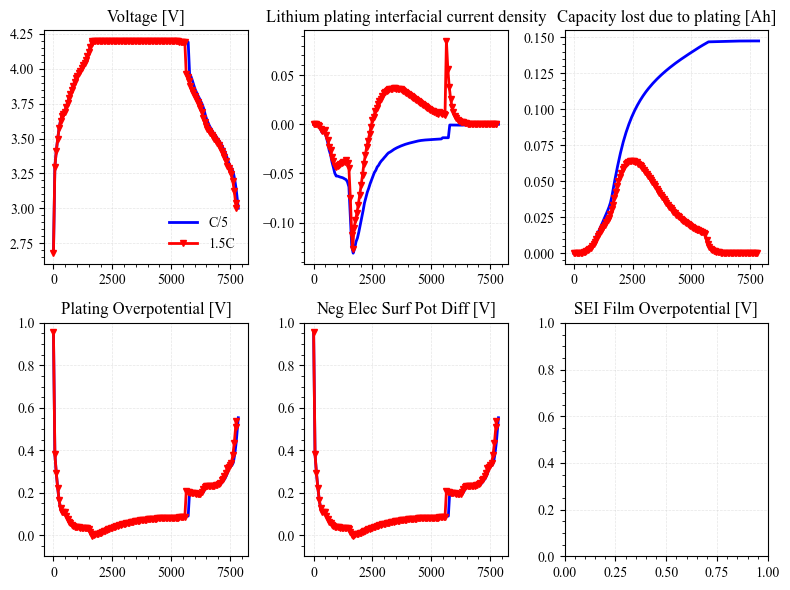

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
# ax1.plot(t3,V3,'g--')
ax1.set_title('Voltage [V]')
ax3 = axes.flat[3]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
# ax3.plot(t3,phi_pl3,'g--')
ax3.set_ylim([-0.1,1])
ax3.set_title('Plating Overpotential [V]')
ax4 = axes.flat[5]
# ax4.plot(t1,phi_sei1,'b')
# ax4.plot(t2,phi_sei2,'rv-')
# ax4.plot(t3,phi_sei3,'g--')
ax4.set_title('SEI Film Overpotential [V]')
ax2 = axes.flat[2]
ax2.plot(t1,Q_Li1,'b')
ax2.plot(t2,Q_Li2,'rv-')
# ax2.plot(t3,Q_Li3,'g--')
ax2.set_title('Capacity lost due to plating [Ah]')
ax3=axes.flat[1]
ax3.plot(t1,I_Li1,'b')
ax3.plot(t2,I_Li2,'rv-')
# ax3.plot(t3,I_Li3,'g--')
ax3.set_title('Lithium plating interfacial current density')
ax5=axes.flat[4]
ax5.plot(t1,phi_del1,'b')
ax5.plot(t2,phi_del2,'rv-')
# ax5.plot(t3,I_Li3,'g--')
ax5.set_ylim([-0.1,1])
ax5.set_title('Neg Elec Surf Pot Diff [V]')
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
# ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
ax1.legend(['C/5','1.5C'])
# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
plt.savefig(fig_DIR+'plating_compare_crate_okane'+'.png')
# plt.savefig(fig_DIR+'plating_compare_spme'+'.png')

In [16]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    # phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    # phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration [mol.m-3]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n

In [17]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2 = plot_vars(solution2)

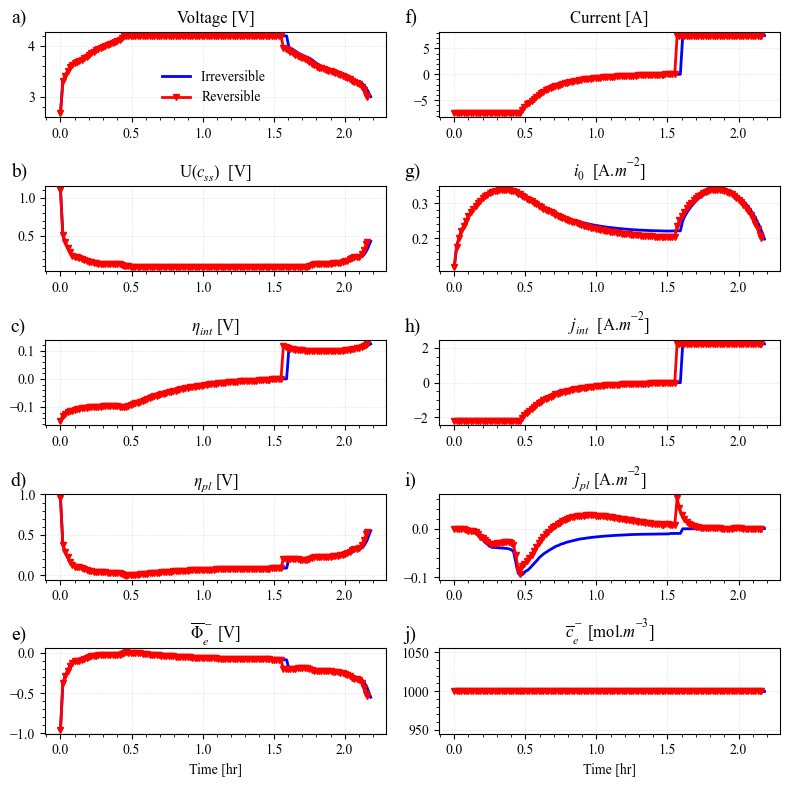

In [18]:
fig, axes = plt.subplots(5, 2, figsize=(8, 8))
ax1 = axes.flat[0]
ax1.plot(t1,V1,'b')
ax1.plot(t2,V2,'rv-')
ax1.set_title('Voltage [V]')
ax2 = axes.flat[2]
ax2.plot(t1,phi_ocp1,'b')
ax2.plot(t2,phi_ocp2,'rv-')
ax2.set_title(r'U($c_{ss})$  [V]')
ax3 = axes.flat[6]
ax3.plot(t1,phi_pl1,'b')
ax3.plot(t2,phi_pl2,'rv-')
ax3.set_title(r'$\eta_{pl}$ [V]')
ax4=axes.flat[3]
ax4.plot(t1,i0_int1,'b')
ax4.plot(t2,i0_int2,'rv-')
ax4.set_title(r'$i_0$  [A.$m^{-2}$]')
ax5=axes.flat[4]
ax5.plot(t1,phi_int1,'b')
ax5.plot(t2,phi_int2,'rv-')
ax5.set_title(r'$\eta_{int}$ [V]')
ax6=axes.flat[7]
ax6.plot(t1,I_Li1,'b')
ax6.plot(t2,I_Li2,'rv-')
ax6.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax7 = axes.flat[1]
ax7.plot(t1,I1,'b')
ax7.plot(t2,I2,'rv-')
ax7.set_title('Current [A]')
ax8=axes.flat[5]
ax8.plot(t1,I_to1,'b')
ax8.plot(t2,I_to2,'rv-')
ax8.set_title(r'$j_{int}$  [A.$m^{-2}$]')
ax9=axes.flat[8]
ax9.plot(t1,phi_e_avg1,'b')
ax9.plot(t2,phi_e_avg2,'rv-')
ax9.set_title(r'$\overline{\Phi}^-_{e}$ [V]')
ax10=axes.flat[9]
ax10.plot(t1,c_e_avg1,'b')
ax10.plot(t2,c_e_avg2,'rv-')
ax10.set_title(r'$\overline{c}^-_{e}$ [mol.$m^{-3}$]')
ax10.set_xlabel("Time [hr]")
ax9.set_xlabel("Time [hr]")
# ax5.set_ylim([-0.1,1])
# ax1.legend(['baseline',r'decreasing $\alpha_{pl}$',r'Increasing $k_{0,pl}$'])
ax1.legend(['Irreversible ','Reversible','Partially Reversible'])
# ax1.legend(['C/5','1.5C'])
axis = [ax1,ax2,ax5,ax3,ax9,ax7,ax4,ax8,ax6,ax10]
labels = ["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)"]
for ax, label in zip(axis,labels):
  ax.text(-0.1,1.1,label,transform=ax.transAxes, fontsize=14)  

# ax1.legend(['SPM','SPMe'])
fig.tight_layout()
# plt.savefig(fig_DIR+'plating_models_parameters'+'.png')
plt.savefig(fig_DIR+'plating_compare_models_1p5C'+'.png')
# plt.savefig(fig_DIR+'plating_compare_spme'+'.png')